# Example 1

## Problem

$$Min \int_0^{t_f}x\sqrt{1+u^2}dt\\
\dot{x} = u\\
u\in\R$$

In [5]:
# Packages

using Pkg
Pkg.activate(".")
#
using OptimalControl
using LinearAlgebra
using ForwardDiff
using DifferentialEquations

using MINPACK # NLE solver
using NLsolve
using LaTeXStrings

  Activating project at `~/control-toolbox/indirect`


## Control-toolbox definition of the problem

In [6]:
t0 = 0
tf = 2
x0 = 1
xf = 1
@def ocp begin
    t ∈ [ t0, tf ], time
    x ∈ R, state
    u ∈ R, control
    x(t0) == x0
    x(tf) == xf
    #ẋ₁(t) == x₂(t)
    #ẋ₂(t) == u(t)
    ẋ(t) ==  u(t)
    ∫(x(t)*(1 + u(t)^2)^(1/2)) → min
end

t ∈ [t0, tf], time
x ∈ R, state
u ∈ R, control
x(t0) == x0
x(tf) == xf
ẋ(t) == u(t)
∫(x(t) * (1 + u(t) ^ 2) ^ (1 / 2)) → min



┌───────┬───────┬─────────┬──────────┬───────────┬─────────────┐
│ times │ state │ control │ dynamics │ objective │ constraints │
├───────┼───────┼─────────┼──────────┼───────────┼─────────────┤
│    ✅ │    ✅ │      ✅ │       ✅ │        ✅ │          ✅ │
└───────┴───────┴─────────┴──────────┴───────────┴─────────────┘


Int_p_0 = [-0.985, -0.735, -0.485, -0.235, 0.015, 0.265, 0.515, 0.765]


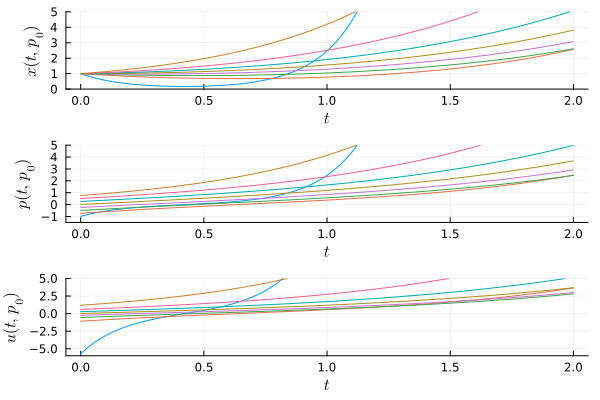

In [74]:
# Compute the  Flow

# 
ε = 1.e-14
#ε = 0.   # there is no derivative of sqrt() in 0
u(x, p) = sign(x[1])*sign(p[1])*sqrt((p[1]^2+ε)/(x[1]^2-p[1]^2))  # contol function

ocp_flow = Flow(ocp, u)   # f is the hamiltonian flow

Int_p0 = -0.985:0.25:0.98
println("Int_p_0 = ", collect(Int_p_0))
Δt = (tf - t0)/100
plt1 = plot()          # the state
plt2 = plot()          # the costate
plt3 = plot()          # the control

for p0 in Int_p0 # Int_p0[1:1]
    flow_p0 = ocp_flow((t0, tf), x0, p0, reltol = 1e-8, abstol = 1e-8, saveat = Δt)
    T = flow_p0.ode_sol.t
    X = flow_p0.ode_sol[1,:]
    P = flow_p0.ode_sol[2,:]
    par = atanh(p0./x0)
    plot!(plt1,T,X)
    plot!(plt2,T,P)
    plot!(plt3,T,u.(X,P))        
    #plot!(plt,flow_p0, control_style=(label="u for p_0",)) # pb car pas les même ordonnées
end

#flow_sol = f((t0, tf), x0, p_sol, saveat = Δt)    

#plot!(plt, flow_sol, control_style=(label="u_sol",))

#plot!(plt[5], ylims=(-6, 6))
plot!(plt1,xlabel = L"t",ylabel=L"x(t,p_0)",legend=false, ylims=(0.,5.))
plot!(plt2,xlabel = L"t",ylabel=L"p(t,p_0)",legend=false, ylims=(-1.5,5.))
plot!(plt3,xlabel = L"t",ylabel=L"u(t,p_0)",legend=false, ylims=(-6.,5.))
plot(plt1,plt2,plt3,layout = (3,1))

In [75]:


# 
grad(f, x) = ForwardDiff.gradient(f, x)

jac(f, x) = ForwardDiff.jacobian(f, x)

H(x,u,p) = -x*sqrt(1+u^2) + u*p
H_true(z) = H(z[1],u(z[1],z[2]),z[2])
#H_true(z) = sqrt(z[2])

#H_true(z)=u(z[1],z[2])
function H_vec(z)
    dz  = grad(H_true,z)
    zpoint = [dz[2] ; -dz[1]]
    return zpoint
end
z0 = [1.;0]
println("H_vec = ", H_vec(z0))

H_vec = [0.0, 1.0]


In [78]:


""" 
   Compute the the right hand side of the hamiltonian system
"""
Hvec! = ocp_flow.rhs!
println(Hvec!)
#z0 = [1.,-0.1]
par = 0.
zpoint = similar(z0)
Hvec!(zpoint,z0,par,t0)
println(zpoint-H_vec(z0))


rhs!


[0.0, 0.0]


In [108]:

"""
   Compute the right hand side of the Jacobi equation
"""
function make_var_Hvec(Hvec!)
    function dim_x(z_δz)
        """ 
            compute du dimension of the state
        """
        N = length(z_δz)
        Δ = 1+2*N
        return Int(round((-1+sqrt(Δ))/2))
    end

    function rhs!(zpoint_δzpoint,z_δz,v,t)
        n = dim_x(z_δz)
        z = z_δz[1:2*n]
        δz = reshape(z_δz[2*n+1:2*n*(n+1)],(2*n,n))
        zpoint = similar(z)
        println("δz = ", δz)
        Hvec!(zpoint,z,v,t)
        Jac = zeros(2*n,2*n)
        println("Jac*δz = ", Jac*δz)
        ForwardDiff.jacobian!(Jac,Hvec!,zpoint,z)
        return [zpoint ; Jac*δz[:]]
    end
    return rhs!
end

jacobi! = make_var_Hvec(Hvec!)

n = ocp.state_dimension
println("n=", n)
println(z0)
println(zeros(2*n)[:])
println(Matrix(1.0I, n, n)[:])

z_δz = [z0 ; [zeros(n,n) ; Matrix(1.0I, n, n)][:]]


#println(ocp)
zpoint_δzpoint = similar(z_δz)
v=0.
jacobi!(zpoint_δzpoint,z_δz,v,t0)

println("zpoint_δzpoint = ", zpoint_δzpoint)

n=1
[1.0, 0.0]
[0.0, 0.0]
[1.0]


n=  1
n=  4
0
[1.0, 0.0]
Jac*δz = [0.0; 0.0;;]


MethodError: MethodError: no method matching (::CTFlows.var"#rhs!#24"{Hamiltonian{NonAutonomous, NonFixed}})(::Vector{ForwardDiff.Dual{ForwardDiff.Tag{CTFlows.var"#rhs!#24"{Hamiltonian{NonAutonomous, NonFixed}}, Float64}, Float64, 2}}, ::Vector{ForwardDiff.Dual{ForwardDiff.Tag{CTFlows.var"#rhs!#24"{Hamiltonian{NonAutonomous, NonFixed}}, Float64}, Float64, 2}})

Closest candidates are:
  (::CTFlows.var"#rhs!#24")(::Union{Real, AbstractVector{<:Real}}, ::Union{Real, AbstractVector{<:Real}}, !Matched::Union{Real, AbstractVector{<:Real}}, !Matched::Real)
   @ CTFlows ~/.julia/packages/CTFlows/Q4XF4/src/hamiltonian.jl:61


In [ ]:

#
# Conjugate points
#
#
function jacobi(δz, par, t)
    x0, p0 = par   # (x_0,p_0)

    x_t = x(t,x0,p0)
    p_t = p(t,x0,p0)
    temp = 1/(x_t^2 - p_t^2)^(3/2)
    return temp*[-x_t*p_t x_t^2 ; -p_t^2 x_t*p_t]*δz
end

function flow_jacobi(t0tf,x0,p0)
    t0, tf = t0tf
    prob = ODEProblem(jacobi,[0;1],t0tf,[x0;p0])
    sol = DifferentialEquations.solve(prob,reltol = 1e-8, abstol = 1e-8) #DifferentialEquations.
    #return sol
end



#   Int_p_0 = -0.98:0.05:-0.3
Int_p_0 = -0.99
   t0tf = (0,2)
   plt4_ana = plot()
   for p0 in Int_p_0 #-5:0.4:1#0.1:0.1:0.1
       sol = flow_jacobi(t0tf,x₀,p0)
       #println(sol)
       plot!(plt4_ana,sol, idxs = (1))
   end

plot!(plt4_ana,xlabel = L"t",ylabel=L"\delta x(t,p_0)",legend=false, ylims=(-10.,10.))
plot(plt4_ana)

In [ ]:

# Define the shooting function
#S(p0) = f(t0, x0, p0, tf)[1] - xf;

#println(S([0. ; 0.]))
#println(S([12. ; 6.]))

##println(S([1. ; 1.]))

# solve the shooting equation
#nl_sol = nlsolve(S, [0.,0.],autodiff = :forward)

# ajouter une fonction qui renvoie une solution du pr de control de type OptimalControl_solution afin de faire le plot

#println("nl_sol = ", nl_sol)
#p_sol = nl_sol.zero
#println("p_sol = ", p_sol)

# draw the solution
#plot(f((t0, tf), x0, p_sol, saveat=[]).ode_sol)

# compute the solution: state, costate, control...
# if we don't have the saveat  option, then we obtain too few points from the numerical solution to have  a nice plot